# Monte Carlo Simulation for Stock Price Prediction and Analysis

> A step-by-step guide to developing a Monte Carlo simulation-based stock price prediction model can be found in this notebook. It visualizes the predicted price progression, uses statistical measures to improve accuracy, and uses historical data to generate random scenarios for future returns. Investors are able to make educated decisions based on various confidence intervals because the quantification section adds a level of uncertainty assessment to the predictions. Overall, the model provides a practical method for comprehending and utilizing Monte Carlo simulation for risk analysis and stock price forecasting.

### Import Packages

In [1]:
# Import external packages
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot  as plt
from scipy.stats import norm
%matplotlib inline

### Observations - Extract Data from Yahoo Finance

[*********************100%%**********************]  1 of 1 completed


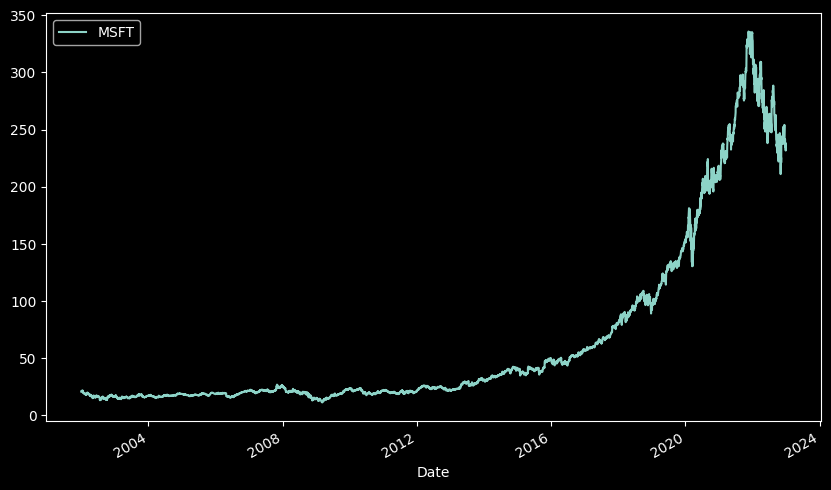

In [2]:
# Extract data from Yahoo Finance
ticker = 'MSFT'
stock_data = pd.DataFrame()
stock_data[ticker] = yf.download(ticker, start='2002-1-1', end='2022-12-31')['Adj Close']

# Plot MSFT closing prices
plt.style.use('dark_background')
stock_data.plot(figsize = (10,6));

### Distributions - Calculate Historical Returns and Statistical Measures

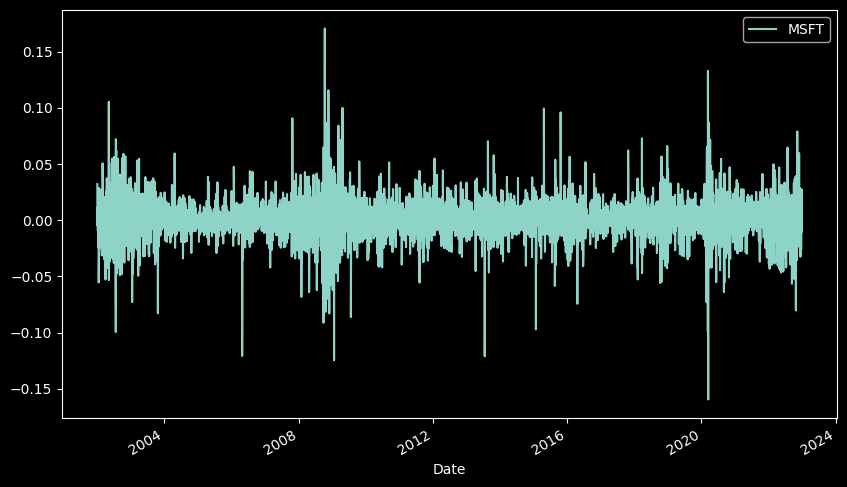

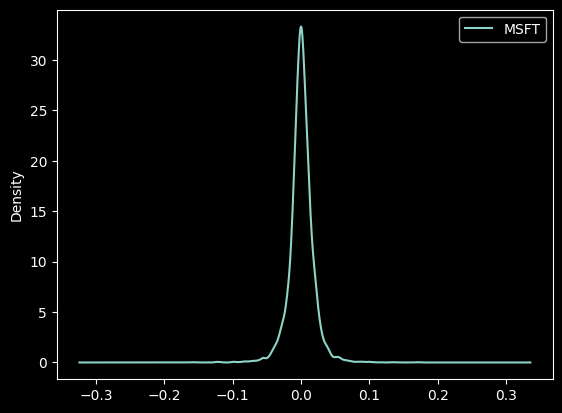

In [3]:
# Calculate historical log returns
log_returns = np.log(1 + stock_data.pct_change())

# Show all the log returns
log_returns.plot(figsize = (10,6));

# Show the distribution of the log returns
log_returns.plot.density();

In [4]:
# Calculate key statistic measures
mean = log_returns.mean()
variance = log_returns.var()
STD = log_returns.std()

### Simulations - Simulate Future Daily Returns and Future Prices

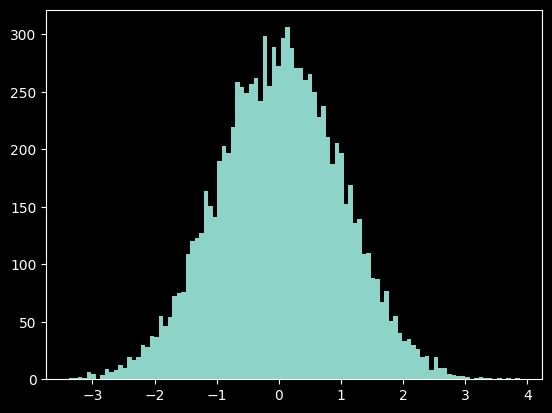

In [5]:
# Generate 10,000 random numbers betwen 0 and 1.
random_numbers = np.random.rand(10000)

# Using those randomly generated numbers to sample from a normal distribution
normal_random_numbers = norm.ppf(random_numbers)

# Plot each of the 10,000 randombly generated numbers from the normal distribution
plt.hist(normal_random_numbers, bins = 100);

In [6]:
# Simulate future daily returns using the above method
t_intervals = 250
simulationns = 10000

daily_logreturns_simulated = STD.values * norm.ppf(np.random.rand(t_intervals, simulationns))
daily_simplereturns_simulated = np.exp(daily_logreturns_simulated)
daily_simplereturns_simulated.shape

(250, 10000)

In [7]:
# Calculating future price progression in each simulation using returns

# Latest known stock price for MSFT
last_price  = stock_data.iloc[-1]

# An array for the price simulations
price_list = np.zeros_like(daily_simplereturns_simulated)

# Set the first row to the starting stock price
price_list[0] = last_price

price_list

array([[236.84625244, 236.84625244, 236.84625244, ..., 236.84625244,
        236.84625244, 236.84625244],
       [  0.        ,   0.        ,   0.        , ...,   0.        ,
          0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        , ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [  0.        ,   0.        ,   0.        , ...,   0.        ,
          0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        , ...,   0.        ,
          0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        , ...,   0.        ,
          0.        ,   0.        ]])

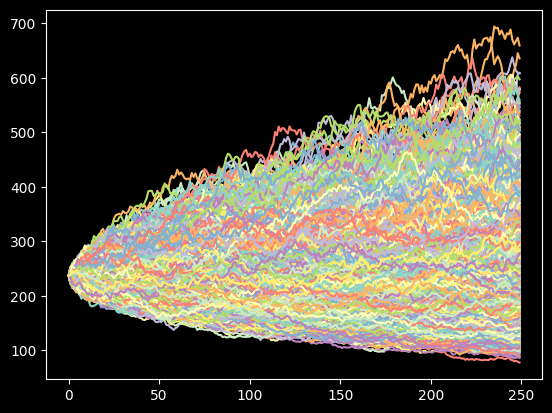

In [8]:
# Apply a for loop for simulated prices
for t in range(1, t_intervals):
    price_list[t] = price_list[t-1] * daily_simplereturns_simulated[t]

# Plot simulated future MSFT prices
plt.plot(price_list);

### Including Drift

In [9]:
# Calculate drift
drift = mean - (0.5*variance)

# Simulate future daily returns
t_intervals = 250
simulationns = 10000

daily_logreturns_simulated = STD.values * norm.ppf(np.random.rand(t_intervals, simulationns))
daily_logreturns_simulated_withdrift = daily_logreturns_simulated + drift.values
daily_simplereturns_simulated_withdrift = np.exp(daily_logreturns_simulated_withdrift)

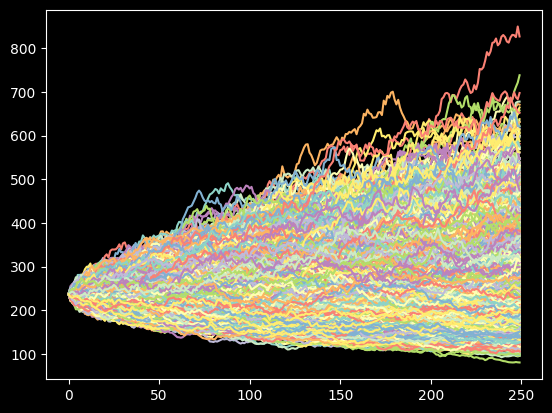

In [10]:
# Create a variable for the latest price of MSFT
last_price  = stock_data.iloc[-1]


# Prepare an array for the price simulations
price_list = np.zeros_like(daily_simplereturns_simulated_withdrift)

# Set the first row to the starting stock price
price_list[0] = last_price

# Apply a for loop for simulated prices
for t in range(1, t_intervals):
    price_list[t] = price_list[t-1] * daily_simplereturns_simulated_withdrift[t]


# Plot simulated future MSFT prices
plt.plot(price_list);

### Quantifications - Examine the worst, average, best scenarios and the probability distribution

In [11]:
# Calculate worst, avg and best scenarios
WorstSim = round(price_list[-1].min(), 2)
AvgSim = round(price_list[-1].mean(), 2)
BestSim = round(price_list[-1].max(), 2)

# Examining the worst, average, and best stock price sceanrios
print('Best and Worst Cases')
print(f'Worst Simulation $/share: {WorstSim}')
print(f'Average Simulation $/share: {AvgSim}')
print(f'BestSimulation $/share: {BestSim}')

# Set up confidence intervals
Mean_Day250Prices = price_list[-1].mean()
SD_Day250Prices = price_list[-1].std()
UpperInterval_1SD = Mean_Day250Prices + 1 * SD_Day250Prices
LowerInterval_1SD = Mean_Day250Prices - 1 * SD_Day250Prices
UpperInterval_2SD = Mean_Day250Prices + 2 * SD_Day250Prices
LowerInterval_2SD = Mean_Day250Prices - 2 * SD_Day250Prices

# Print out the price range within the confidence intervals
print('\n' + 'Confidence Intervals')
print(f'1 Sigma (1 S.D.): 68% confident that price after 250 days will fall between: ${round(LowerInterval_1SD, 2)} and ${round(UpperInterval_1SD, 2)}')
print(f'2 Sigma (2 S.D.): 95% confident that price after 250 days will fall between: ${round(LowerInterval_2SD, 2)} and ${round(UpperInterval_2SD, 2)}')

Best and Worst Cases
Worst Simulation $/share: 80.47
Average Simulation $/share: 265.31
BestSimulation $/share: 826.98

Confidence Intervals
1 Sigma (1 S.D.): 68% confident that price after 250 days will fall between: $189.78 and $340.85
2 Sigma (2 S.D.): 95% confident that price after 250 days will fall between: $114.25 and $416.38


Perform Value at Risk (VaR) Calculation and Plot Simulated Price Histogram

Value at Risk (VaR) at 5.0% confidence level: $161.74


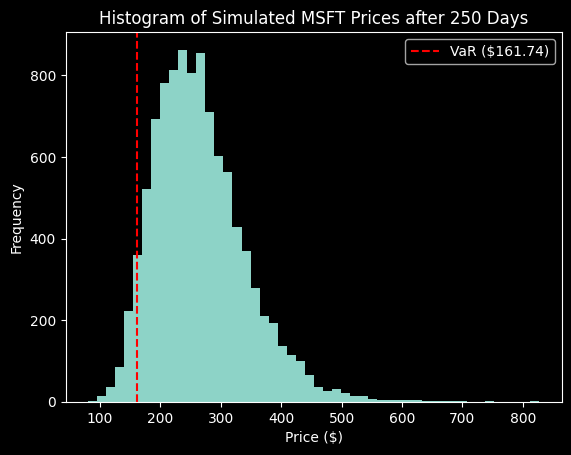

In [13]:
# Calculate Value at Risk (VaR)
confidence_level = 0.05
VaR = np.percentile(price_list[-1], confidence_level*100)

print(f'Value at Risk (VaR) at {confidence_level*100}% confidence level: ${round(VaR, 2)}')

# Plot histogram of the final simulated prices
plt.hist(price_list[-1], bins=50)
plt.axvline(x=VaR, color='r', linestyle='--', label=f'VaR (${round(VaR, 2)})')
plt.title('Histogram of Simulated MSFT Prices after 250 Days')
plt.xlabel('Price ($)')
plt.ylabel('Frequency')
plt.legend()
plt.show()

 Perform Expected Shortfall (CVaR) Calculation

In [14]:
# Calculate Conditional Value at Risk (CVaR) or Expected Shortfall
CVaR = price_list[-1][price_list[-1] <= VaR].mean()
print(f'Conditional Value at Risk (CVaR) at {confidence_level*100}% confidence level: ${round(CVaR, 2)}')

Conditional Value at Risk (CVaR) at 5.0% confidence level: $145.67


Calculate and Plot Cumulative Returns

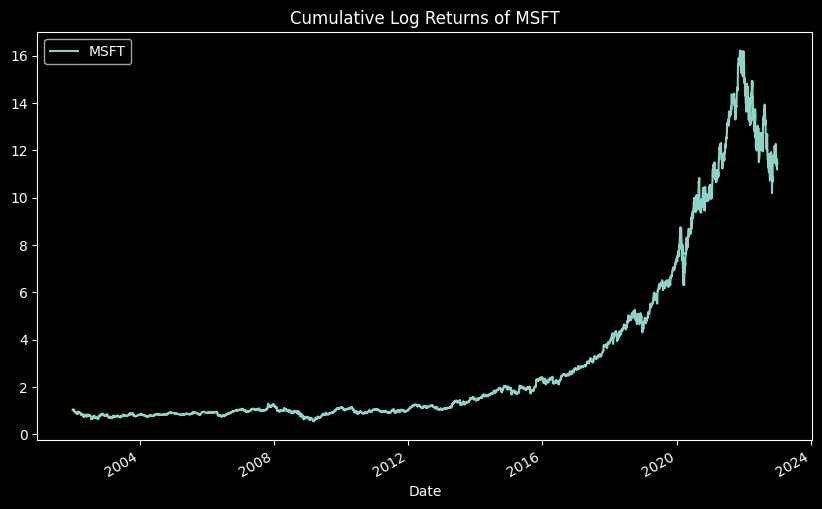

In [15]:
# Calculate cumulative returns
cumulative_returns = np.exp(log_returns.cumsum())

# Plot cumulative returns
cumulative_returns.plot(figsize=(10, 6))
plt.title('Cumulative Log Returns of MSFT')
plt.show()

Show Summary Statistics of Simulated Prices

In [16]:
# Summary statistics of the simulated prices
summary_stats = pd.DataFrame({
    'Worst Case': [WorstSim],
    'Average Case': [AvgSim],
    'Best Case': [BestSim],
    'VaR': [round(VaR, 2)],
    'CVaR': [round(CVaR, 2)],
    'Mean': [round(Mean_Day250Prices, 2)],
    'Standard Deviation': [round(SD_Day250Prices, 2)]
})

print('Summary Statistics of Simulated MSFT Prices:')
print(summary_stats)


Summary Statistics of Simulated MSFT Prices:
   Worst Case  Average Case  Best Case     VaR    CVaR    Mean  \
0       80.47        265.31     826.98  161.74  145.67  265.31   

   Standard Deviation  
0               75.53  
